In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Invalid device or cannot modify virtual devices once initialized.")
    pass

In [3]:
htr = pd.read_csv("handwrittentext.csv")

In [4]:
images = htr["Image Location"].values.tolist()
labels = htr["Text"].values.tolist()
characters = set(char for label in labels for char in label)

In [5]:
# Image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

In [6]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary = list(characters), num_oov_indices = 0, mask_token = None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True
)

In [7]:
def split_data(images, labels, train_size = 0.9, shuffle = True):
    size = len(htr)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels = 1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm = [1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding = "UTF-8"))
    return {"image": img, "label": label}

In [8]:
class HandWrittenText(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, input_img_paths, text):
        self.batch_size = batch_size
        self.input_img_paths = images
        self.text = text

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_text = self.text[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + (img_width, img_height,) + (1,), dtype = "float32")
        y = np.zeros((self.batch_size, max_length,), dtype = "int32")
        
        for i,j,k in zip(range(self.batch_size), batch_input_img_paths,  batch_text):
            sample = encode_single_sample(j,k)
            x[i] = sample["image"].numpy().tolist()
            y[i] = sample["label"].numpy().tolist() + [0]*(max_length - len(sample["label"].numpy().tolist()))
        
        return x, y

In [9]:
train_gen = HandWrittenText(16, x_train, y_train)
val_gen = HandWrittenText(16, x_valid, y_valid)

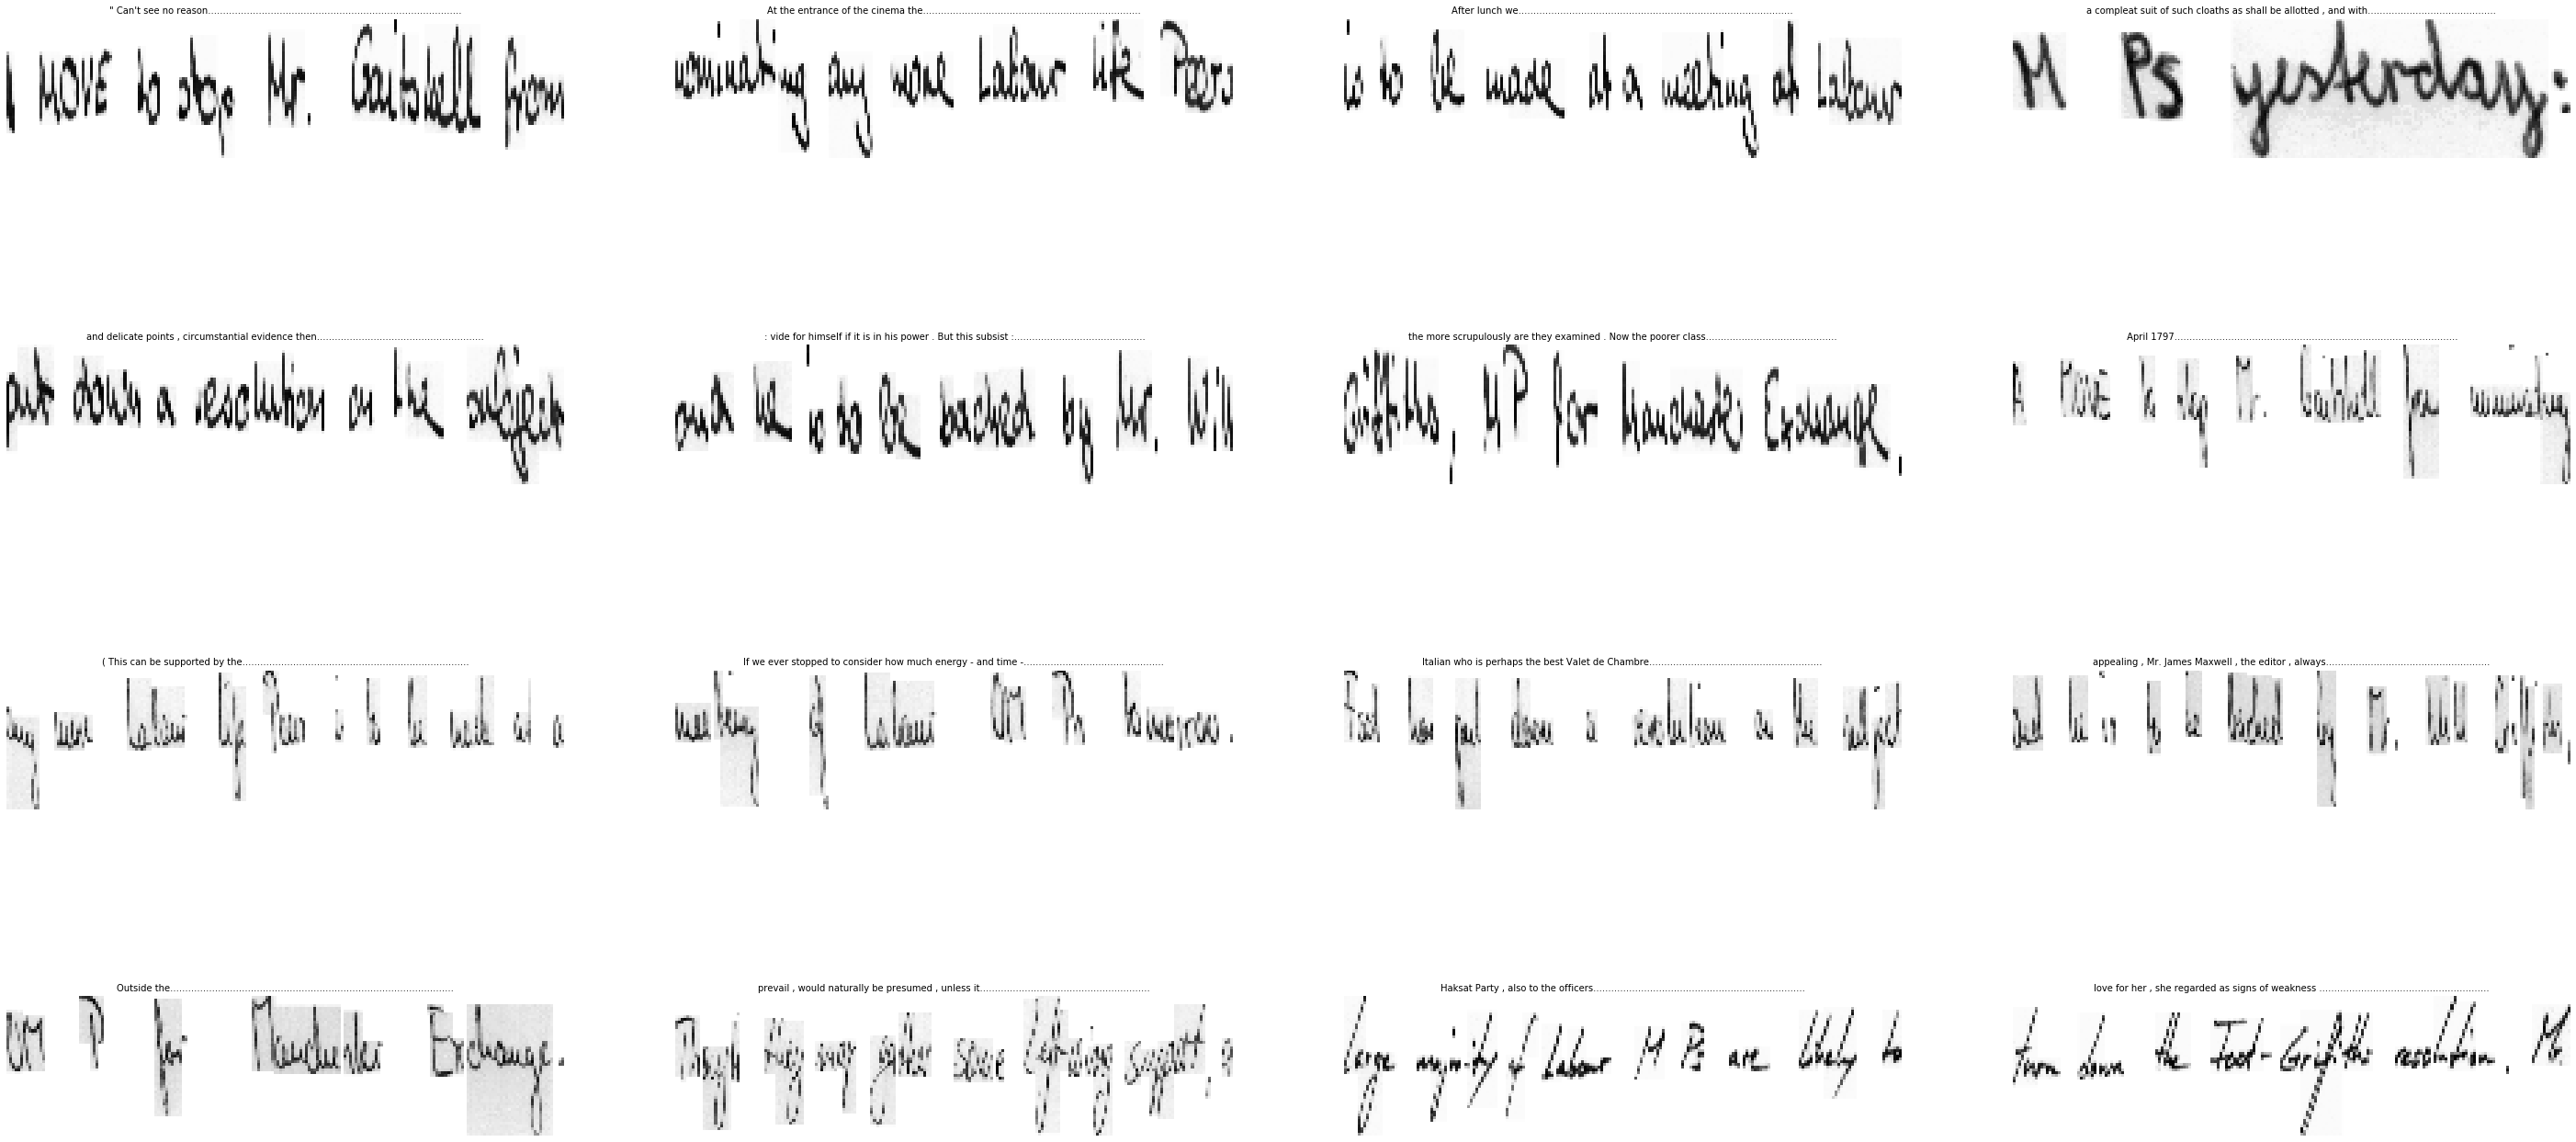

In [10]:
_, ax = plt.subplots(4, 4, figsize = (50, 25))
for images, text in train_gen:
    for i in range(16):
        img = (images[i] * 255).astype("uint8")
        label = tf.strings.reduce_join(num_to_char(text[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap = "gray")
        ax[i // 4, i % 4].set_title(label, size = 10)
        ax[i // 4, i % 4].axis("off")
    break
plt.show()